<a href="https://colab.research.google.com/github/sindhu213/Pytorch/blob/main/NLP/seq2seq_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task: Translate from English to Hindi

In [2]:
import re
import torch
import random
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator

## Text Preprocessing

In [3]:
root_dir = 'drive/My Drive/assets/hin_eng.txt'

In [4]:
sentences = []
with open(root_dir,'r') as file:
  for line in file: 
    sentences.append(line.split('\t')[:2])

In [5]:
def tokenize_en(text):
  tokenized = re.sub(r'[^\w\s+]',' ',text.lower())
  return tokenized.split()

def tokenize_hi(text):
  tokenized = re.sub(r'[!#$%&()+,-./।:;"<=>?[\]^_`{|}~]',' ',text)
  return tokenized.split()

In [6]:
def yield_tokens(iterable,lang):
  for en,hi in iterable:
    if lang is 'en': yield tokenize_en(en)
    else: yield tokenize_hi(hi)

In [7]:
en_vocab = build_vocab_from_iterator(yield_tokens(sentences,'en'),min_freq=1,specials=["<unk>","<pad>","<bos>","<eos>"])
en_vocab.set_default_index(0)

hi_vocab = build_vocab_from_iterator(yield_tokens(sentences,'hi'),min_freq=1,specials=["<unk>","<pad>","<bos>","<eos>"])
hi_vocab.set_default_index(0)

In [8]:
print("en_vocab size: ",len(en_vocab))
print("hi_vocab size: ",len(hi_vocab))

en_vocab size:  2358
hi_vocab size:  2863


In [9]:
en_pipeline = lambda x: en_vocab(["<bos>",*tokenize_en(x),"<eos>"])
hi_pipeline = lambda x: hi_vocab(["<bos>",*tokenize_hi(x),"<eos>"])

In [10]:
def collate_batch(data_iter):
  src,tgt_data,tgt_label = [],[],[]
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for x,y in data_iter:
    src_encoded = en_pipeline(x)
    src.append(torch.tensor(src_encoded,dtype=torch.int64,device=device))
    tgt_encoded = hi_pipeline(y)
    tgt_data.append(torch.tensor(tgt_encoded[:-1],dtype=torch.int64,device=device))
    tgt_label.append(torch.tensor(tgt_encoded[1:],dtype=torch.int64,device=device))
  
  src = pad_sequence(src,batch_first=True,padding_value=1)
  tgt_data = pad_sequence(tgt_data,batch_first=True,padding_value=1)
  tgt_label = pad_sequence(tgt_label,batch_first=True,padding_value=1)
  
  return src.to(device), tgt_data.to(device), tgt_label.to(device)

In [11]:
torch.manual_seed(42)
batch_size = 64

train_dl = DataLoader(sentences,batch_size=batch_size,shuffle=True,collate_fn=collate_batch,drop_last=True)  

## Model Definition

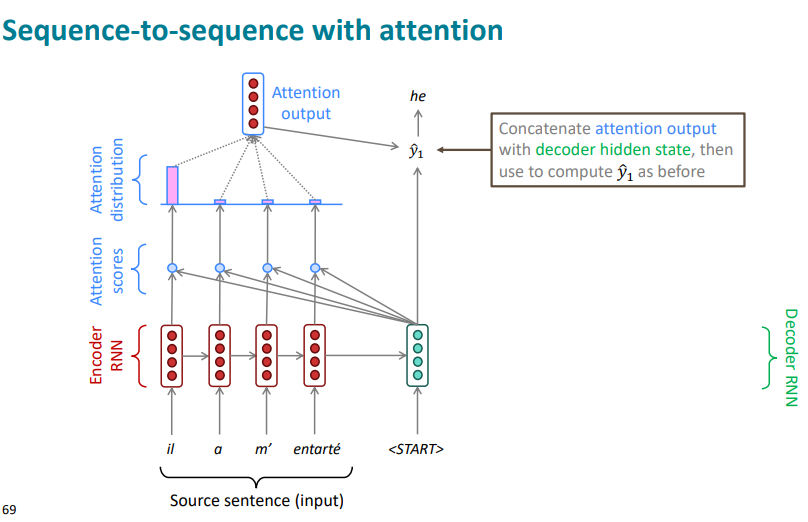

**Image Source**: [CS224n](https://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture07-nmt.pdf)

In [12]:
class Encoder(nn.Module):

  def __init__(self,vocab_size,embed_dim,rnn_hidden_size):
    super(Encoder,self).__init__()
    self.embedding = nn.Embedding(vocab_size,embed_dim,padding_idx=1)
    self.lstm = nn.LSTM(embed_dim,rnn_hidden_size,batch_first=True)

  def forward(self,input):
    """
    INPUT: [batch_size,len(english_sentence)]

    IMPLCIT:
      hidden: [1,batch_size,rnn_hidden_size]
      cell: [1,batch_size,rnn_hidden_size]

    OUTPUT:
      out: [batch_size,len(english_sentence),rnn_hidden_size]
      hidden: [1,batch_size,rnn_hidden_size]
      cell: [1,batch_size,rnn_hidden_size]
    """
    
    ## out: [batch_size,len(english_sentence),embed_dim]
    out = self.embedding(input)

    ## out: [batch_size,len(english_sentence),rnn_hidden_size]
    ## hidden: [1,batch_size,rnn_hidden_size]
    ## cell: [1,batch_size,rnn_hidden_size]
    out,(hidden,cell) = self.lstm(out)

    return out,hidden,cell

In [13]:
class Decoder(nn.Module):

  def __init__(self,vocab_size,embed_dim,rnn_hidden_size):      
    super(Decoder,self).__init__()
    self.embedding = nn.Embedding(vocab_size,embed_dim,padding_idx=1)
    self.lstm = nn.LSTM(embed_dim,rnn_hidden_size,batch_first=True)
    self.softmax = nn.Softmax(dim=1)
    self.fc = nn.Linear(2*rnn_hidden_size,vocab_size)

  def forward(self,input,hidden,cell,src_out):    
    """
    INPUT: 
      input: [batch_size]
      hidden: [1,batch_size,rnn_hidden_size]
      cell: [1,batch_size,rnn_hidden_size]
      src_out: [batch_size,len(english_sentence),rnn_hidden_size]

    OUTPUT:
       out: [batch_size,vocab_size]
       hidden: [1,batch_size,rnn_hidden_size]
       cell: [1,batch_size,rnn_hidden_size]
    """

    ## out: [batch_size,1]
    out = input.unsqueeze(1)

     ## out: [batch_size,1,embed_dim]
    out = self.embedding(out)

    ## out: [batch_size,1,rnn_hidden_size]
    ## hidden: [1,batch_size,rnn_hidden_size]
    ## cell: [1,batch_size,rnn_hidden_size]
    out,(hidden,cell) = self.lstm(out,(hidden,cell))

    ## attn_score: [batch_size,len(english_sentence),1]
    attn_score = torch.bmm(src_out,out.permute(0,2,1))

    ## attn_dist: [batch_size,len(english_sentence),1]
    attn_dist = self.softmax(attn_score)

    ## attn_out: [batch_size,1,rnn_hidden_size]
    attn_out = torch.bmm(attn_dist.permute(0,2,1),src_out)

    ## attn_state: [batch_size, 2*rnn_hidden_size]
    attn_state = torch.cat([out,attn_out],dim=2).squeeze(1)

    ## out: [batch_size,vocab_size]
    out = self.fc(attn_state)

    return out,hidden,cell

In [14]:
class seq2seq(nn.Module):

  def __init__(self,encoder,decoder):
    super(seq2seq,self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,src,tgt,teacher_force_ratio=0.5):
    """
    INPUT:
      src: [batch_size,len(english_sentence)]
      tgt: [batch_size,len(hindi_sentence)]

    OUTPUT:
      output: [batch_size,len(hindi_sentence),hi_vocab_size]
    """
    batch_size = tgt.shape[0]
    tgt_len = tgt.shape[1]

    output = torch.zeros(batch_size,tgt_len,hi_vocab_size).to(device)

    ## src_out: [batch_size,len(hindi_sentence),rnn_hidden_size]
    ## hidden: [1,batch_size,rnn_hidden_size]
    ## cell: [1,batch_size,rnn_hidden_size]
    src_out,hidden,cell = self.encoder(src)

    ## x: [batch_size]
    x = tgt[:,0]

    for t in range(tgt_len):

      ## out: [batch_size,vocab_size]
      ## hidden: [batch_size,1,rnn_hidden_size]
      ## cell: [batch_size,1,rnn_hidden_size]
      out,hidden,cell = self.decoder(x,hidden,cell,src_out)

      output[:,t,:] = out
      best_guess = out.argmax(1)
      x = tgt[:,t] if random.random() < teacher_force_ratio else best_guess   
    
    return output

## Model Initialization

In [15]:
en_vocab_size = len(en_vocab)
hi_vocab_size = len(hi_vocab)
embed_dim = 1024
rnn_hidden_dim = 512

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(en_vocab_size,embed_dim,rnn_hidden_dim)
decoder = Decoder(hi_vocab_size,embed_dim,rnn_hidden_dim)

model = seq2seq(encoder,decoder).to(device)
model

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(2358, 1024, padding_idx=1)
    (lstm): LSTM(1024, 512, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(2863, 1024, padding_idx=1)
    (lstm): LSTM(1024, 512, batch_first=True)
    (softmax): Softmax(dim=1)
    (fc): Linear(in_features=1024, out_features=2863, bias=True)
  )
)

In [17]:
def count_parameters(model):
  return sum(param.numel() for param in model.parameters() if param.requires_grad)

print("Number of trainable params in Encoder: {:,}".format(count_parameters(encoder)))
print("Number of trainable params in Decoder: {:,}".format(count_parameters(decoder)))
print("Number of trainable params in seq2seq: {:,}".format(count_parameters(model)))

Number of trainable params in Encoder: 5,564,416
Number of trainable params in Decoder: 9,016,111
Number of trainable params in seq2seq: 14,580,527


## Model Training

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
def train(data_iter):
  model.train()
  epoch_loss = 0.0

  ## src: [batch_size,len(english_sentence)]
  ## tgt_data: [batch_size,len(hindi_sentence)]
  ## tgt_label: [batch_size,len(hindi_sentence)]
  for src,tgt_data,tgt_label in data_iter:
    optimizer.zero_grad()

    ## seq_length: [len(hindi_sentence)]
    seq_length = tgt_label.shape[1]

    ## pred: [batch_size,len(hindi_sentence),hi_vocab_size]
    pred = model(src,tgt_data)

    ## pred: [batch_size*len(hindi_sentence),-1]
    pred = pred.reshape(batch_size*seq_length,-1)

    ## tgt_label: [batch_size*len(hindi_sentence)]
    tgt_label = tgt_label.reshape(-1)

    ## loss: [hi_vocab_Size]
    loss = loss_fn(pred,tgt_label)

    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
  
  return epoch_loss/len(data_iter)

In [27]:
num_epochs = 20
for epoch in range(num_epochs):
  loss = train(train_dl)
  print("EPOCH: {},    LOSS: {: .4f}".format(epoch,loss))

EPOCH: 0,    LOSS:  0.4416
EPOCH: 1,    LOSS:  0.4301
EPOCH: 2,    LOSS:  0.3991
EPOCH: 3,    LOSS:  0.3637
EPOCH: 4,    LOSS:  0.3431
EPOCH: 5,    LOSS:  0.3297
EPOCH: 6,    LOSS:  0.3287
EPOCH: 7,    LOSS:  0.3120
EPOCH: 8,    LOSS:  0.2856
EPOCH: 9,    LOSS:  0.2909
EPOCH: 10,    LOSS:  0.2820
EPOCH: 11,    LOSS:  0.2658
EPOCH: 12,    LOSS:  0.2530
EPOCH: 13,    LOSS:  0.2418
EPOCH: 14,    LOSS:  0.2256
EPOCH: 15,    LOSS:  0.2194
EPOCH: 16,    LOSS:  0.2300
EPOCH: 17,    LOSS:  0.2288
EPOCH: 18,    LOSS:  0.2105
EPOCH: 19,    LOSS:  0.1961


## Test Translation

In [28]:
def translate(src):
  model.eval()
  src_tokenized = torch.tensor(en_pipeline(src),device=device).unsqueeze(0)

  seed = ["<bos>"]
  tgt_tokenized = hi_vocab(seed)
  src_out, hidden, cell = encoder(src_tokenized)

  with torch.no_grad():
      while tgt_tokenized[-1] != 3 and len(tgt_tokenized) < 10:     
        input = torch.tensor(tgt_tokenized[-1],device=device).unsqueeze(0)   
        pred,hidden,cell = decoder(input,hidden,cell,src_out)
        probs = torch.softmax(pred[0,:],dim=0)      
        prediction = torch.multinomial(probs,num_samples=1).item()

        if prediction in [0,1]:
          continue
        tgt_tokenized.append(prediction)

  itos = hi_vocab.get_itos()
  tokens = [itos[i] for i in tgt_tokenized]
  return tokens

In [30]:
torch.manual_seed(42)
translate("Can I help you?")

['<bos>', 'क्या', 'मैं', 'आपकी', 'मदद', 'कर', 'सकता', 'हूँ', '<eos>']

In [31]:
torch.manual_seed(42)
translate("How did you come here?")

['<bos>', 'यहाँ', 'यहाँ', 'से', 'क्यों', 'आए', '<eos>']

In [43]:
torch.manual_seed(42)
translate("I am going there to meet her")

['<bos>', 'मैं', 'उससे', 'से', 'मिलना', 'ही', 'हूँ', '<eos>']